In [1]:
import random
import copy
import numpy as np
import theano as T
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%capture  --no-stderr --no-stdout --no-display
%%R

library(ggplot2)
library(reshape)
library(grid)
library(dplyr)
library(gridExtra)
library(lme4)

paper_theme_2 <- theme_light() + theme(axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14, colour="black"),
 title =element_text(size=16, face='bold'))

paper_theme_3 <- theme( axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14),
  strip.text=element_text(size=16),
  axis.line.x = element_line(colour = "black"), 
  axis.line.y = element_line(colour = "black"),
  legend.title=element_text(size=18),
  legend.text=element_text(size=16))  

  

/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Need help getting started? Try the cookbook for R:
http://www.cookbook-r.com/Graphs/

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:reshape’:

    rename


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/pyth

In [3]:
%%R --o data_resp

data_resp_loc <- read.csv("data/estimation_dot_gaze.csv", sep="\t")
data_tracker <- read.csv("data/estimation_tracker_data.csv", sep="\t")
data_tracker$trial_id <- data_tracker$trial_id - 1
data_resp_loc$trial_id <- data_resp_loc$trial_id - 1


data_resp_loc <- data_resp_loc %>%
                filter(belowX >=0) 
                #mutate(belowX=max(0.1,belowX))

trials <- (unique(data_resp_loc$trial_id))

data_tracker <- data_tracker %>%
                group_by(trial_id) %>%
                filter(trial_id %in% trials)


data_resp_loc$id <- seq.int(1, nrow(data_resp_loc))


data_resp <- data_resp_loc %>%
     #mutate(Dots_Counted=max(min(5*Dots_Shown, Dots_Counted),0.1*Dots_Shown)) %>%

      filter(gazeDist > 0 & Dots_Shown < 150 & Dots_Shown >= 10) %>%
      #mutate(gazeDist=max(0,gazeDist)) %>%

      mutate(err=Dots_Counted - Dots_Shown) %>%
      mutate(abs_err = abs(err)) %>%
      mutate(within_x = 2/(1 + exp(-0.6 -0.2*belowX)) - 1) %>%
      group_by(trial_id) %>% 
      mutate(belowX = mean(belowX)) %>%
      mutate(within_x = mean(within_x)) %>%
      mutate(nLooks=mean(nLooks)) %>%
      #mutate(within_x=mean(pInGaze**0.2)) %>%

      mutate(within_x_tot = sum(within_x)) %>%
      mutate(nLooks = mean(nLooks)) %>%
      mutate(pathLength = mean(pathLength)) %>%
      mutate(medFix = mean(medFix)) %>%
      mutate(mean_dist=sum(gazeDist)/Dots_Shown) %>%
      mutate(mean_abs_err = mean(abs_err)) %>%
      mutate(pct_err=err/Dots_Shown) %>%
        mutate(abs_pct_err=abs_err/Dots_Shown) %>%

      top_n(n=1, wt=id)  %>%
      filter(abs_pct_err <= 1.) %>%
      group_by(Subject, pid)%>%
      filter(length(Subject) > 0) 


data_tracker <- data_tracker %>%
                  filter(ValidityLeft == 0 & ValidityRight == 0) %>%

                mutate(av_x = (GazePointXLeft +GazePointXRight)/2) %>%
                mutate(av_y = (GazePointYLeft +GazePointYRight)/2) %>%
                group_by(trial_id) %>%
                mutate(Time = round(max(TimeStamp)/100)/10)

data_tracker$id <- seq.int(1,nrow(data_tracker))
data_resp$Time <- as.factor(round(data_resp$Time,2))



In [4]:
data_resp = pandas2ri.ri2py(data_resp)

In [85]:
def remove_n(ls,n):
    ret = []
    for l in ls:
        l_rem = l[:n]
        ret.append(l_rem)
    return ret


subj_group = data_resp.groupby(["pid", "Subject", "Time"])
dots_shown,dots_counted,pct_area,seen,n_look,times=[],[],[],[],[],[]
for i,subj in subj_group:
    times.append([float(i) for i in list(subj["Time"])])
    dots_shown.append(list(subj["Dots_Shown"]))
    dots_counted.append(list(subj["Dots_Counted"]))
    pct_area.append(list(subj["pctArea"] * 0.95))
    seen.append(list(subj["within_x_tot"]))
    n_look.append(list(subj["nLooks"]))

ns = [len(n) for n in seen]
min_n = min(ns)



dots_shown = remove_n(dots_shown, min_n)
dots_counted = remove_n(dots_counted, min_n)
pct_area = remove_n(pct_area, min_n)
seen = remove_n(seen, min_n)
n_look = remove_n(n_look, min_n)
times = remove_n(times, min_n)


dots_shown=np.array(dots_shown)
dots_counted=np.array(dots_counted)
pct_area=np.array(pct_area)
seen=np.array(seen)
n_look = np.array(n_look)
times = np.array(times)
unseen = dots_shown - seen

with pm.Model() as mod:
    
    beta_grp_mu = pm.HalfNormal("slope_grp_mu", sd=2,testval=1)

    #weber_grp_mu = pm.HalfNormal("weber_grp_mu",sd=1,testval=0.25)
    beta_grp_sd = pm.HalfNormal("slope_grp_sd", sd=2,testval=1)
    weber_grp_sd = pm.HalfNormal("weber_grp_sd",sd=1,testval=0.3)

    beta = pm.Normal("slope", mu=beta_grp_mu, sd=beta_grp_sd, shape=(len(dots_shown), 1))
    weber = pm.HalfNormal("weber", sd=weber_grp_sd, shape=(len(dots_shown), 1))
    #time_slope = pm.Normal("time_slope", mu=0, sd=10, shape=(len(dots_shown), 1))

    #dev_unseen = pm.HalfNormal("dev_unseen", sd=5, shape=(len(dots_shown), 1))
    #weber = (weber + abs(weber))/2. + 1e-8 #this removes negatives
    
    
    guess_mean = beta * dots_shown
    guess_mean = guess_mean
    
    
    guess_sd = weber * abs(guess_mean) #* times ** time_slope
    
    #guess_sd += dev_unseen * 
    
    lkhd = pm.Normal("lkhd", mu=guess_mean, sd=guess_sd, observed=dots_counted)
    trace = pm.sample(1500, tune=500, cores=2, njobs=2, chains=2)
    

    
    
    

summary = pm.summary(trace)
print(summary)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [weber_log__, slope, weber_grp_sd_log__, slope_grp_sd_log__, slope_grp_mu_log__]
100%|██████████| 2000/2000 [00:17<00:00, 114.18it/s]


                  mean        sd  mc_error   hpd_2.5  hpd_97.5   n_eff  \
slope__0_0    0.724365  0.042512  0.000719  0.644180  0.810572  3000.0   
slope__1_0    0.721442  0.051409  0.000722  0.622765  0.822912  3000.0   
slope__2_0    0.744249  0.037894  0.000601  0.670948  0.819500  3000.0   
slope__3_0    0.771818  0.049887  0.000710  0.670696  0.867472  3000.0   
slope__4_0    0.498333  0.020363  0.000300  0.459928  0.539489  3000.0   
slope__5_0    0.609749  0.029996  0.000429  0.551970  0.669354  3000.0   
slope__6_0    0.612303  0.035263  0.000516  0.544285  0.680124  3000.0   
slope__7_0    0.716963  0.048421  0.000700  0.629314  0.818842  3000.0   
slope__8_0    0.725094  0.058506  0.000916  0.604715  0.836687  3000.0   
slope__9_0    0.887802  0.059271  0.000936  0.758281  0.990547  3000.0   
slope__10_0   0.797701  0.056663  0.000865  0.684457  0.908202  3000.0   
slope__11_0   0.949005  0.071169  0.001176  0.812149  1.089535  3000.0   
slope__12_0   0.888487  0.069308  0.00

In [86]:
summary_mean = summary["mean"]
summary_sd = summary["sd"]

vals = {}
rownames = list(summary.index)
for i in range(len(rownames)):
    rowname = rownames[i]
    rowname = rowname[:rowname.find("__")]
    if "grp" in rowname:
        val = [summary_mean[i] for _ in range(len(data_resp))]
        val_sd = [summary_sd[i] for _ in range(len(data_resp))]
    else:
        val = [summary_mean[i] for _ in range(ns[i%len(ns)])]
        val_sd = [summary_sd[i] for _ in range(ns[i%len(ns)])]

    if rowname not in vals:
        vals[rowname] = copy.copy(val)
        vals[rowname+"_sd"] = copy.copy(val_sd)

    else:
        vals[rowname] += copy.copy(val)
        vals[rowname+"_sd"] += copy.copy(val_sd)

        
summary_vals = {}
for val in vals:
    summary_vals[val] = vals[val]
    print(val)
    print(len(vals[val]))
          
          
summary_vals = pd.DataFrame(summary_vals)

for i in data_resp:
    summary_vals[i] = data_resp[i]
pandas2ri.py2ri(summary_vals)

slope_grp_m
1652
weber_grp_s
1652
slope
1652
slope_grp_m_sd
1652
slope_sd
1652
slope_grp_s_sd
1652
weber_grp_s_sd
1652
weber_sd
1652
slope_grp_s
1652
weber
1652


slope,slope_grp_m,slope_grp_m_sd,...,mean_abs_err,pct_err,abs_pct_err
0.724365,0.772085,0.019387,...,2.000000,0.111111,0.111111
0.724365,0.772085,0.019387,...,29.000000,-0.325843,0.325843
0.724365,0.772085,0.019387,...,6.000000,-0.166667,0.166667
0.724365,0.772085,0.019387,...,41.000000,-0.476744,0.476744
...,...,...,...,...,...,...
0.691944,0.772085,0.019387,...,1.000000,-0.047619,0.047619
0.691944,0.772085,0.019387,...,25.000000,-0.500000,0.500000



Call:
lm(formula = real_weber ~ pctArea * time_num, data = summary_vals)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.131868 -0.035565 -0.007768  0.026888  0.217933 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.216418   0.006263  34.556  < 2e-16 ***
pctArea          -0.075619   0.020333  -3.719 0.000207 ***
time_num         -0.005365   0.005325  -1.008 0.313802    
pctArea:time_num  0.013785   0.009048   1.523 0.127841    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05979 on 1582 degrees of freedom
Multiple R-squared:  0.02659,	Adjusted R-squared:  0.02474 
F-statistic:  14.4 on 3 and 1582 DF,  p-value: 2.93e-09


Call:
lm(formula = real_weber ~ pathLength * time_num, data = summary_vals)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.125455 -0.034158 -0.006729  0.024201  0.222555 

Coefficients:
                      Estimate Std. Error t value P

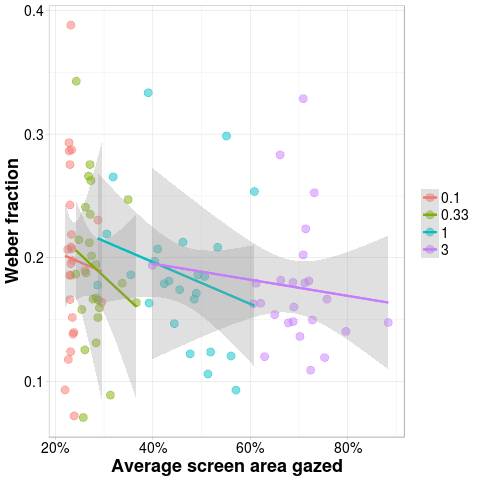

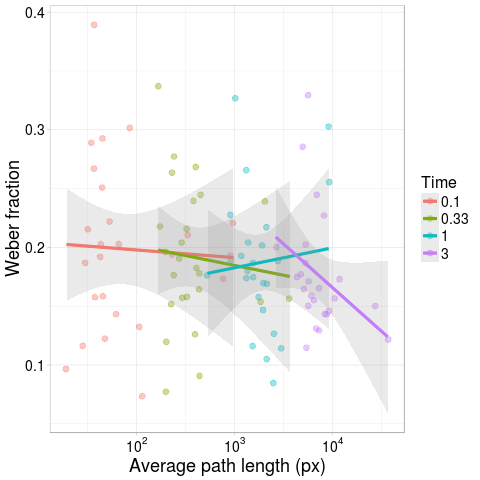

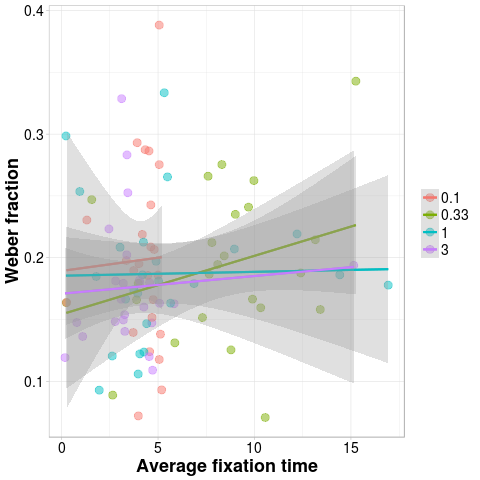

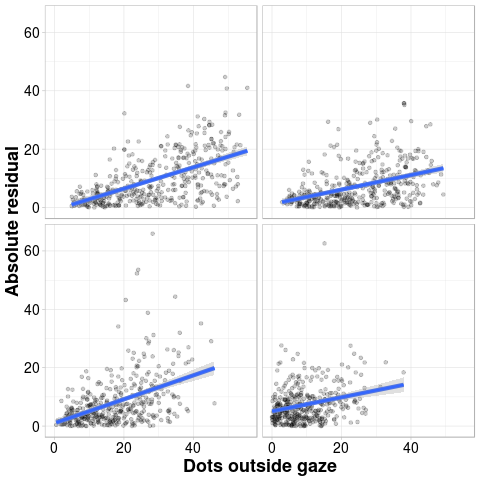

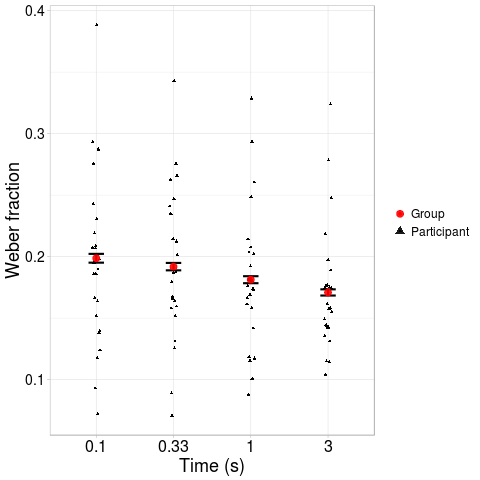

In [122]:
%%R -i summary_vals summary



#get model estimates for each participant
summary_vals <- summary_vals %>%
            mutate(time_num=as.numeric(as.character(Time))) %>%
             mutate(unseen = (Dots_Shown - within_x_tot)) %>%

            filter(!grepl("alx", Subject) & !((unseen/Dots_Shown > 0.5) & (time_num == 3))) %>%
           # mutate(pathLength=log(pathLength)) %>%
           # mutate(medFix=log(medFix+1)) %>%
             mutate(model_guess = slope * Dots_Shown) %>%

             mutate(model_noise = weber * model_guess)  %>%
             mutate(dev = (Dots_Counted - model_guess)) %>%
             mutate(abs_dev = abs(dev)) %>%

            mutate(real_weber = weber*slope) 
#just the mean values of parameters
#estimated in the regression

mean_reg_vals <- summary_vals %>%
            group_by(pid, Subject,Time) %>%

            mutate(real_weber = mean(real_weber))  %>%

            mutate(real_weber_sd = mean(weber_sd)) %>%
           # group_by(pid, Subject, Time) %>%
             mutate(pctArea =mean(pctArea)) %>%

             mutate(pathLength =mean(pathLength)) %>%
            mutate(medFix = mean(medFix)) %>%
            top_n(n=1,wt=id) 


p.1 <- ggplot(data=summary_vals) +
        geom_errorbar(aes(x=Dots_Shown, ymin=model_guess - model_noise,
                                 ymax=model_guess+model_noise, color="Model"), alpha=0.02,width=0.25,size=10) +
        geom_point(aes(x=Dots_Shown, y=Dots_Counted,color="Human"), alpha=0.5) +
        geom_line(aes(x=Dots_Shown, y=model_guess, color="Model"), alpha=0.9) +

        scale_color_manual(values=c("black","blue")) +
 
        facet_wrap(~pid) +
        paper_theme_2 + theme(legend.title=element_blank(), legend.text=element_text(size=14), 
                                  strip.text=element_blank()) +
        geom_abline(linetype="dashed") +
        xlab("Dots shown") + ylab("Estimate") +
        coord_cartesian(ylim=c(0,120))


p.2 <- ggplot(data=summary_vals, aes(x=real_weber, y=pct_err)) +
        geom_point(alpha=0.1, size=1.5) +
        stat_smooth(method="lm") +
        paper_theme_2 + 
        theme(legend.title=element_blank(), 
                legend.text=element_text(size=14)) +
       # stat_summary(fun.y="mean", color="blue", size=2, geom="point")
        stat_summary(fun.data="mean_cl_boot", 
                         color="blue", size=0.5, geom="errorbar", width=0.01)

p.3 <- ggplot(data=mean_reg_vals, aes(x=pctArea, y=real_weber, color=Time)) +
        geom_point(size=3.5, alpha=0.5) + 
        stat_smooth(method="lm", alpha=0.8, se=FALSE) +
        stat_smooth(method="lm", alpha=0.3, se=TRUE) +
        paper_theme_2 + theme(legend.title=element_blank(), legend.text=element_text(size=14))  +
        scale_x_log10(breaks=seq.int(0.0,1,0.2)*100) +
        scale_x_continuous(labels = scales::percent) +
        xlab("Average screen area gazed") + ylab("Weber fraction")


library(MASS) # to access Animals data sets
library(scales) # to access break formatting functions
# x and y axis 

p.4 <- ggplot(data=mean_reg_vals, aes(x=pathLength, y=real_weber, color=Time)) +
        geom_jitter(size=2.5, alpha=0.4, width=0.01,height=0.01) + 
        stat_smooth(method="lm",  span=4,alpha=0.8, se=FALSE, size=1.5) +
        stat_smooth(method="lm",  span=4,alpha=0.2, se=TRUE) +
        paper_theme_2 + theme(legend.text=element_text(size=14))  +

          scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
              labels = trans_format("log10", math_format(10^.x))) +
        xlab("Average path length (px)") + ylab("Weber fraction") +
            theme(axis.title.x=element_text(face="plain"),
                            axis.title.y=element_text(face="plain"),
                  legend.title=element_text(face="plain"))
        #facet_wrap(~Time, scale_x)
                        
p.4
ggsave("figs/PL_weber.png", width=5, height=4, dpi=500)


p.5 <- ggplot(data=mean_reg_vals, aes(x=medFix, y=real_weber, color=Time)) +
        geom_point(size=3.5, alpha=0.5) + 
        stat_smooth(method="lm", alpha=0.8, se=FALSE) +
        stat_smooth(method="lm", alpha=0.3, se=TRUE) +
        paper_theme_2 + theme(legend.title=element_blank(), legend.text=element_text(size=14))  +

        xlab("Average fixation time") + ylab("Weber fraction")
                        
                        
p.6 <- ggplot(data=summary_vals, aes(x=unseen, y=abs_dev)) +
            geom_point(alpha=0.2) +
        
        stat_smooth(method="lm", alpha=0.8, se=FALSE, size=2, span=2) +
        stat_smooth(method="lm", alpha=0.3, se=TRUE, span=2) +
        paper_theme_2 + theme(legend.text=element_text(size=14), strip.text=element_blank())  +
        xlab("Dots outside gaze") + ylab("Absolute residual") +     
        #coord_cartesian(ylim=c(-25, 20)) +
       # coord_cartesian(ylim=c(0, 30)) +
       # facet_wrap(~Subject)
         facet_wrap(~Time)
                        
                        
p.7 <- ggplot(data=summary_vals, aes(x=Time, y=real_weber)) +
        
      # stat_summary(fun.y="mean", geom="bar", alpha=0.4) +
        #geom_jitter(data=mean_reg_vals,aes(x=Time, y=real_weber), width=0.1, height=0.0) +
       stat_summary(fun.y="mean", geom="point", size=1, position=position_dodge(width=0.1),
                    aes(group=Subject, color="Participant", shape="Participant")) +


        stat_summary(geom="errorbar", width=0.2,size=1.0, fun.data="mean_se") +
      stat_summary(geom="point", fun.y="mean", size=3., alpha=0.9, aes(color="Group", shape="Group")) +
    #stat_summary(fun.y="mean", geom="line", size=4) +
        scale_color_manual(name="a", values=c("Red", "Black"),labels=c("Group", "Participant")) +
        scale_shape_manual(name="a", values=c(19, 17), labels=c("Group", "Participant")) +
        #geom_errorbar(aes(ymin=real_weber - real_weber_sd, ymax=real_weber+real_weber_sd)) +
      paper_theme_2 + theme(legend.text=element_text(size=12), 
                            strip.text=element_blank(), 
                            axis.text.x=element_text(size=16),
                         axis.title.x=element_text(face="plain"),
                            axis.title.y=element_text(face="plain")) +
        theme(legend.text=element_text(size=12), legend.title=element_blank()) +

            ylab("Weber fraction") + xlab("Time (s)")                         
p.7

ggsave("figs/time_weber.png", width=5,height=4,dpi=500)

#summary(lm(data=summary_vals, pct_err ~ weber))

#summary(lm(data=mean_reg_vals, slope ~ weber))
r.0 <- summary(lm(data=summary_vals, real_weber ~ pctArea * time_num))
r.1 <- summary(lm(data=mean_reg_vals, real_weber ~ pathLength * time_num))
r.2 <- summary(lm(data=summary_vals, real_weber ~ pathLength * time_num))

r.3 <- summary(lm(data=mean_reg_vals, real_weber ~ medFix))
r.4 <- summary(lm(data=summary_vals, real_weber ~ medFix * time_num))


r.5 <- summary(lmer(data=summary_vals, real_weber ~ time_num + (1|Subject)))
r.6 <- summary(lm(data=summary_vals, abs_dev ~  unseen)) 

#r.7 <- summary(lm(data=summary_vals, Dots_Counted ~ pathLength + within_x_tot + time_num + model_guess))
r.7 <- summary(lm(data=summary_vals, dev ~ unseen + time_num + Dots_Shown))
r.8 <- summary(lmer(data=summary_vals, dev ~ unseen + time_num + Dots_Shown + (1|Subject)))

r.9 <- summary(lm(data=summary_vals, within_x ~ pathLength))
                        
#print(p.1)
#print(p.2)
print(p.3)
print(p.4)
print(p.5)
print(p.6)
print(p.7)
print(r.0)
#print(r.1)
print(r.2)
#print(r.3)
print(r.4)
print(r.5)
#print(r.6)
#print(r.7)
#print(r.8)
#print(r.9)
     